In [1]:
import numpy as np 
from numpy import asarray
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential , load_model
from keras.layers import Dense, Embedding, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.layers.convolutional import Conv1D
from keras.layers.core import Activation, Dropout, Dense
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint , EarlyStopping
from keras.utils.np_utils import to_categorical
import re

In [2]:
data = pd.read_csv('raw_data.csv')
data = data.drop(['Image','Source','Headline'] , axis = 1)
data
#1 if related , 0 if not related

,Sno,Date,Covid,Sentiment,Description
0,0,2020-04-29,1,0,Rajasthan on Wednesday reported 74 new coronav...
1,1,2020-04-29,1,0,The total number of coronavirus cases in Delhi...
2,2,2020-04-30,0,1,"Condoling the demise of actor Rishi Kapoor, PM..."
3,3,2020-04-30,0,0,Congress leader Rahul Gandhi condoled Rishi Ka...
4,4,2020-04-30,1,1,As a sign of respect for healthcare profession...
...,...,...,...,...,...
4067,4067,2020-03-01,0,0,"Adhering to a policy of ""zero tolerance"" for c..."
4068,4068,2020-03-01,0,1,"While addressing a rally in South Carolina, US..."
4069,4069,2020-03-01,0,0,After AAP government granted sanction to Delhi...
4070,4070,2020-03-01,0,0,"Kamil Siedcynski, a Polish student at Kolkata'..."


In [3]:
#Check Whether News is for Covid or Not! Add to new Dataframe
covid_data = data[(data['Covid']==1)]
covid_data.insert(0,'Snum' , range(0,0+len(covid_data)))
covid_data = covid_data.set_index('Snum')
covid_data

,Sno,Date,Covid,Sentiment,Description
Snum,,,,,
0,0,2020-04-29,1,0,Rajasthan on Wednesday reported 74 new coronav...
1,1,2020-04-29,1,0,The total number of coronavirus cases in Delhi...
2,4,2020-04-30,1,1,As a sign of respect for healthcare profession...
3,5,2020-04-30,1,1,Madhya Pradesh Chief Minister Shivraj Singh Ch...
4,6,2020-04-30,1,1,"J&K administration has brought back 6,355 labo..."
...,...,...,...,...,...
3240,3968,2020-03-03,1,0,Uttar Pradesh CM Yogi Adityanath has said that...
3241,3970,2020-03-02,1,0,An Italian tourist has tested positive for cor...
3242,3993,2020-03-02,1,0,Two positive cases of coronavirus have been co...


In [4]:
#Exploring the Description of Some News
covid_data["Description"][7]

'Coronavirus cases in the Nashik district of Maharashtra have risen to 276 after 71 people tested positive, officials have stated. The fresh cases, most of which are from Malegaon, included six police personnel and three children aged three months, 5 years and 11 years respectively. The death toll in Nashik district stands at 12.'

# We have 3245 data of Covid Related News

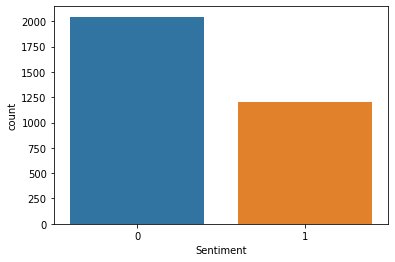

In [5]:
sns.countplot(x = 'Sentiment' , data = covid_data)
#1 is positive , 0 is negative

# Preprocessing

In [6]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [7]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)


In [8]:
descript = []
sentences = list(covid_data['Description'])
for sen in sentences:
    descript.append(preprocess_text(sen))

In [9]:
descript[7]

'Coronavirus cases in the Nashik district of Maharashtra have risen to after people tested positive officials have stated The fresh cases most of which are from Malegaon included six police personnel and three children aged three months years and years respectively The death toll in Nashik district stands at '

In [10]:
#80% for training set and 20% testing set
X_train , X_test, y_train , y_test = train_test_split(descript , covid_data['Sentiment'],test_size=0.20,random_state=42)

# Preparing the Embedding Layer

In [11]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [12]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train , padding='post' , maxlen = maxlen)
X_test = pad_sequences(X_test , padding='post' , maxlen = maxlen)

# Using GloVe Embeddings

In [13]:
embeddings_dictionary = dict()
glove_file = open("glove.6B.100d.txt", encoding="utf-8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()
print('GloVe file opened Successfully')

GloVe file opened Successfully


In [14]:
embedding_matrix = np.zeros((vocab_size,100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

# Classification using Convolutional Neural Network

In [15]:
cnn_model = Sequential()

embedding_layer = Embedding(vocab_size , 100,weights=[embedding_matrix] , input_length=maxlen , trainable = False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [16]:
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          944900    
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,009,157
Trainable params: 64,257
Non-trainable params: 944,900
_________________________________________________________________
None


In [17]:
history = cnn_model.fit(X_train,y_train,batch_size = 128,epochs=6,verbose=1,validation_split=0.2)

Epoch 1/6
17/17 [==============================] - 2s 128ms/step - loss: 0.6589 - acc: 0.6296 - val_loss: 0.5323 - val_acc: 0.7308
Epoch 2/6
17/17 [==============================] - 1s 61ms/step - loss: 0.4846 - acc: 0.7746 - val_loss: 0.5175 - val_acc: 0.7346
Epoch 3/6
17/17 [==============================] - 1s 48ms/step - loss: 0.4290 - acc: 0.8102 - val_loss: 0.5149 - val_acc: 0.7365
Epoch 4/6
17/17 [==============================] - 1s 42ms/step - loss: 0.3849 - acc: 0.8516 - val_loss: 0.4881 - val_acc: 0.7577
Epoch 5/6
17/17 [==============================] - 1s 42ms/step - loss: 0.3427 - acc: 0.8858 - val_loss: 0.4861 - val_acc: 0.7654
Epoch 6/6
17/17 [==============================] - 1s 42ms/step - loss: 0.3076 - acc: 0.9104 - val_loss: 0.4784 - val_acc: 0.7635


In [18]:
score = cnn_model.evaluate(X_test ,y_test , verbose =1)

21/21 [==============================] - 0s 6ms/step - loss: 0.4813 - acc: 0.7550


In [19]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.4813041090965271
Test Accuracy: 0.7550076842308044


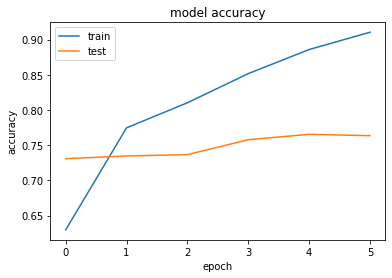

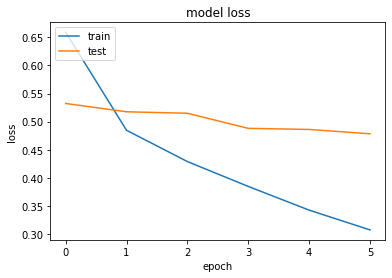

In [20]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [43]:
tweet = descript[658]
print(tweet)

In its mouthpiece Saamana Shiv Sena said Congress Rahul Gandhi has created model code of conduct on how opposition should behave when the country is in crisis Rahul recognised the coronavirus threat in advance warned the government to take necessary steps it added Sena further said that the thoughts expressed by Rahul are like brainstorming session for the government 


In [44]:
tweet = tokenizer.texts_to_sequences(tweet)

flat_list = []
for sublist in tweet:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

tweet = pad_sequences(flat_list, padding='post', maxlen=maxlen)
cnn_model.predict(tweet)

array([[0.6036631]], dtype=float32)

# LSTM

In [65]:
lstm_model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128,return_sequences=True,dropout=0.33))
lstm_model.add(Dense(64,activation = 'relu'))
lstm_model.add(Dense(1,activation='sigmoid'))
lstm_model.compile(optimizer = 'adam' , loss='binary_crossentropy' , metrics =['acc'])

In [66]:
checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True,
                              mode='auto', period=1,save_weights_only=False)

In [67]:
print(lstm_model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          944900    
_________________________________________________________________
lstm_3 (LSTM)                (None, 100, 128)          117248    
_________________________________________________________________
dense_7 (Dense)              (None, 100, 64)           8256      
_________________________________________________________________
dense_8 (Dense)              (None, 100, 1)            65        
Total params: 1,070,469
Trainable params: 125,569
Non-trainable params: 944,900
_________________________________________________________________
None


In [68]:
history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=8, verbose=1, validation_split=0.2,
                        callbacks = checkpoint1)

Epoch 1/8
17/17 [==============================] - 7s 429ms/step - loss: 0.6610 - acc: 0.6172 - val_loss: 0.6007 - val_acc: 0.6762
Epoch 2/8
17/17 [==============================] - 7s 384ms/step - loss: 0.5861 - acc: 0.6657 - val_loss: 0.5761 - val_acc: 0.6472
Epoch 3/8
17/17 [==============================] - 5s 315ms/step - loss: 0.5651 - acc: 0.6996 - val_loss: 0.5832 - val_acc: 0.6658
Epoch 4/8
17/17 [==============================] - 6s 355ms/step - loss: 0.5602 - acc: 0.7024 - val_loss: 0.5721 - val_acc: 0.6827
Epoch 5/8
17/17 [==============================] - 6s 381ms/step - loss: 0.5428 - acc: 0.7142 - val_loss: 0.5468 - val_acc: 0.7347
Epoch 6/8
17/17 [==============================] - 7s 410ms/step - loss: 0.5356 - acc: 0.7273 - val_loss: 0.5329 - val_acc: 0.7371
Epoch 7/8
17/17 [==============================] - 6s 348ms/step - loss: 0.5075 - acc: 0.7501 - val_loss: 0.5136 - val_acc: 0.7516
Epoch 8/8
17/17 [==============================] - 6s 361ms/step - loss: 0.5123 - a

In [69]:
lstm_score = lstm_model.evaluate(X_test, y_test, verbose=1)

21/21 [==============================] - 2s 93ms/step - loss: 0.4904 - acc: 0.7645: 1s - loss: 0.53


In [70]:
print("Test Score:", lstm_score[0])
print("Test Accuracy:", lstm_score[1])

Test Score: 0.49036261439323425
Test Accuracy: 0.7644529938697815


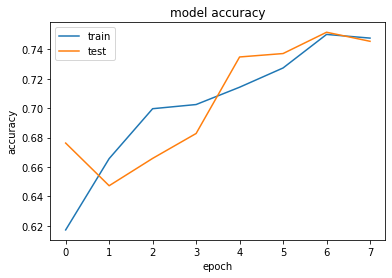

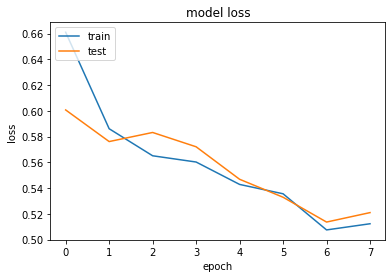

In [71]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# Making Predictions using LSTM Model

In [72]:
tweett = descript[789]
print(tweett)

In Jharkhand West Singhbhum district robots will serve food and give medicine to COVID patients at two hospitals in order to protect doctors and health workers from getting the virus The remote controlled COBOT Robotics is developed by District Deputy Development Commissioner Aditya Ranjan and will provide food and medicine to patients without human intervention 


In [73]:
tweett = tokenizer.texts_to_sequences(tweett)

flatt_list = []
for sublistt in tweett:
    for itemm in sublistt:
        flatt_list.append(itemm)
        
flatt_list = [flatt_list]

tweett = pad_sequences(flatt_list, padding='post', maxlen=maxlen)
result = lstm_model.predict(tweett)
pos = np.argmax(result)

In [74]:
print(result[0][pos])

[0.67569464]
